In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import seaborn as sns
from locale import normalize
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, normalized_mutual_info_score, homogeneity_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
spa_adata = sc.read_h5ad("../../data/ST/seqfish/seqfish_data.h5ad")
spa_adata.X = spa_adata.X.toarray()

sc.pp.normalize_total(spa_adata)
sc.pp.log1p(spa_adata)

spa_adata.obsm['spatial'] = np.hstack([spa_adata.obs.x_global_affine.values.reshape(-1,1), spa_adata.obs.y_global_affine.values.reshape(-1,1)])
df_spa = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
sq.gr.spatial_neighbors(spa_adata)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=20,
)
imp_adatas = {}
method_mapping = {'transImpute':"TransImpRaw", 'transImpSpa':"TransImpSpa", 'transImpCls':"TransImpCls", 'transImpClsSpa':"TransImpClsSpa"}
output_root = "../../output"
eval_res = {'se_moranI':{}, 'pred_corr':{}, 'I':{}}
for file in os.listdir(output_root):
    if file.split('_')[-1].split('.')[0] not in {'spaGE', 'transImpute', 'stPlus', 'Tangram', 'transImpSpa', "transImpCls", 'transImpClsSpa'}: continue
    if len(file.split(".")[0].split('_')) != 3: continue    
    spa, rna, method = file.split(".")[0].split('_')
    if spa.lower() != 'seqfish': continue
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    df_res = pd.read_csv(os.path.join(output_root,file), index_col=0)
    imp_adata = sc.AnnData(df_res.values)
    imp_adata.var_names = df_res.columns
    imp_adata.obsm['spatial'] = spa_adata.obsm['spatial']
    
    method = method if not method in method_mapping else method_mapping[method]
    imp_adatas[method] = imp_adata
    imp_adatas[method] = imp_adata    
    corrs = calc_corr(df_spa, df_res, df_res.columns, False, True)
    sq.gr.spatial_neighbors(imp_adata)
    sq.gr.spatial_autocorr(
        imp_adata,
        n_jobs=20,
        mode='moran',
    )
    sel = (~np.isnan(imp_adata.uns['moranI'].I))
    if np.sum(sel) < imp_adata.n_vars:
        print(f'({spa} {rna} {method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I[sel] - imp_adata.uns['moranI'].I[sel])
    eval_res['se_moranI'][method] = squ_err_moranI
    eval_res['pred_corr'][method] = pd.Series(corrs, df_res.columns)
    eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I[sel], df_res.columns)


In [3]:
TransImpSpa_reduced_err_wrt_tangram = np.median((eval_res['se_moranI']["Tangram"] - eval_res['se_moranI']["TransImpSpa"]) / eval_res['se_moranI']["Tangram"])
print(f"TransImpSpa avg. reduced err wrt tangram: {TransImpSpa_reduced_err_wrt_tangram:.3}")

TransImpSpa avg. reduced err wrt tangram: 0.805


In [4]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_I         = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_I['truth'] = spa_adata.uns['moranI'].loc[df_I.index.values,:].I
imp_adatas = dict(sorted(imp_adatas.items()))

[Text(0, 0.5, 'Cosine Similarity')]

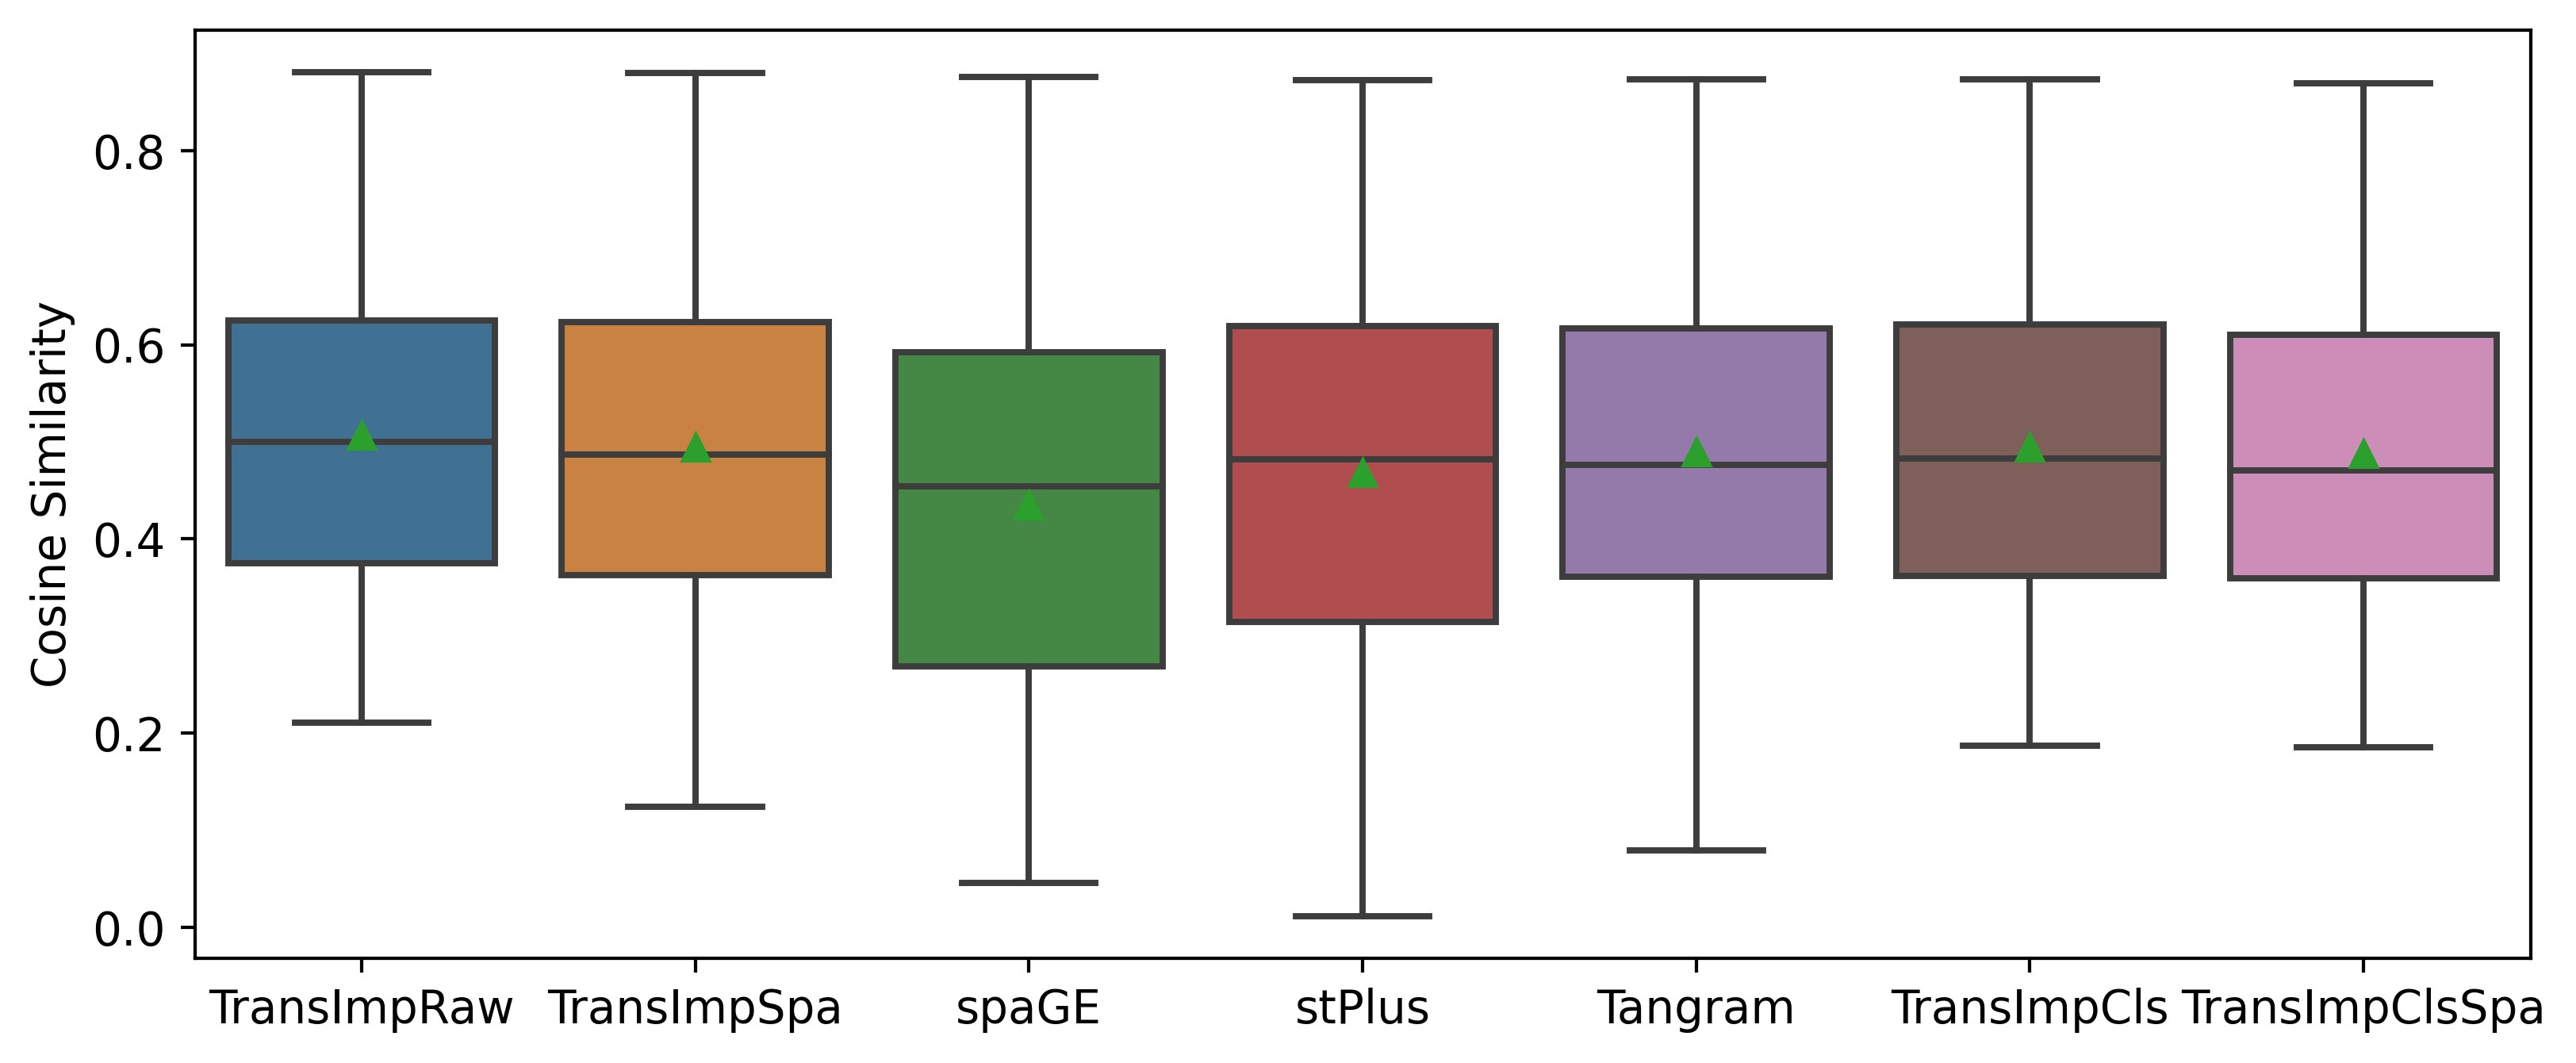

In [5]:
plt.figure(figsize=(10, 4), dpi= 380)
plt.rcParams.update({"font.size":11, 'axes.titlesize':12})
method_order = ["TransImpRaw", "TransImpSpa", "spaGE", "stPlus", "Tangram", "TransImpCls", "TransImpClsSpa"]
color = ['#3274A1', '#E1812C', '#3A923A', '#C03D3E', '#9372B2', '#845B53', '#D684BD', '#c780e8']
sns.boxplot(data = df_corr, showmeans=True, order=method_order, palette=color).set(
    ylabel="Cosine Similarity"
)

[Text(0, 0.5, "Moran's I Mean Squared Error")]

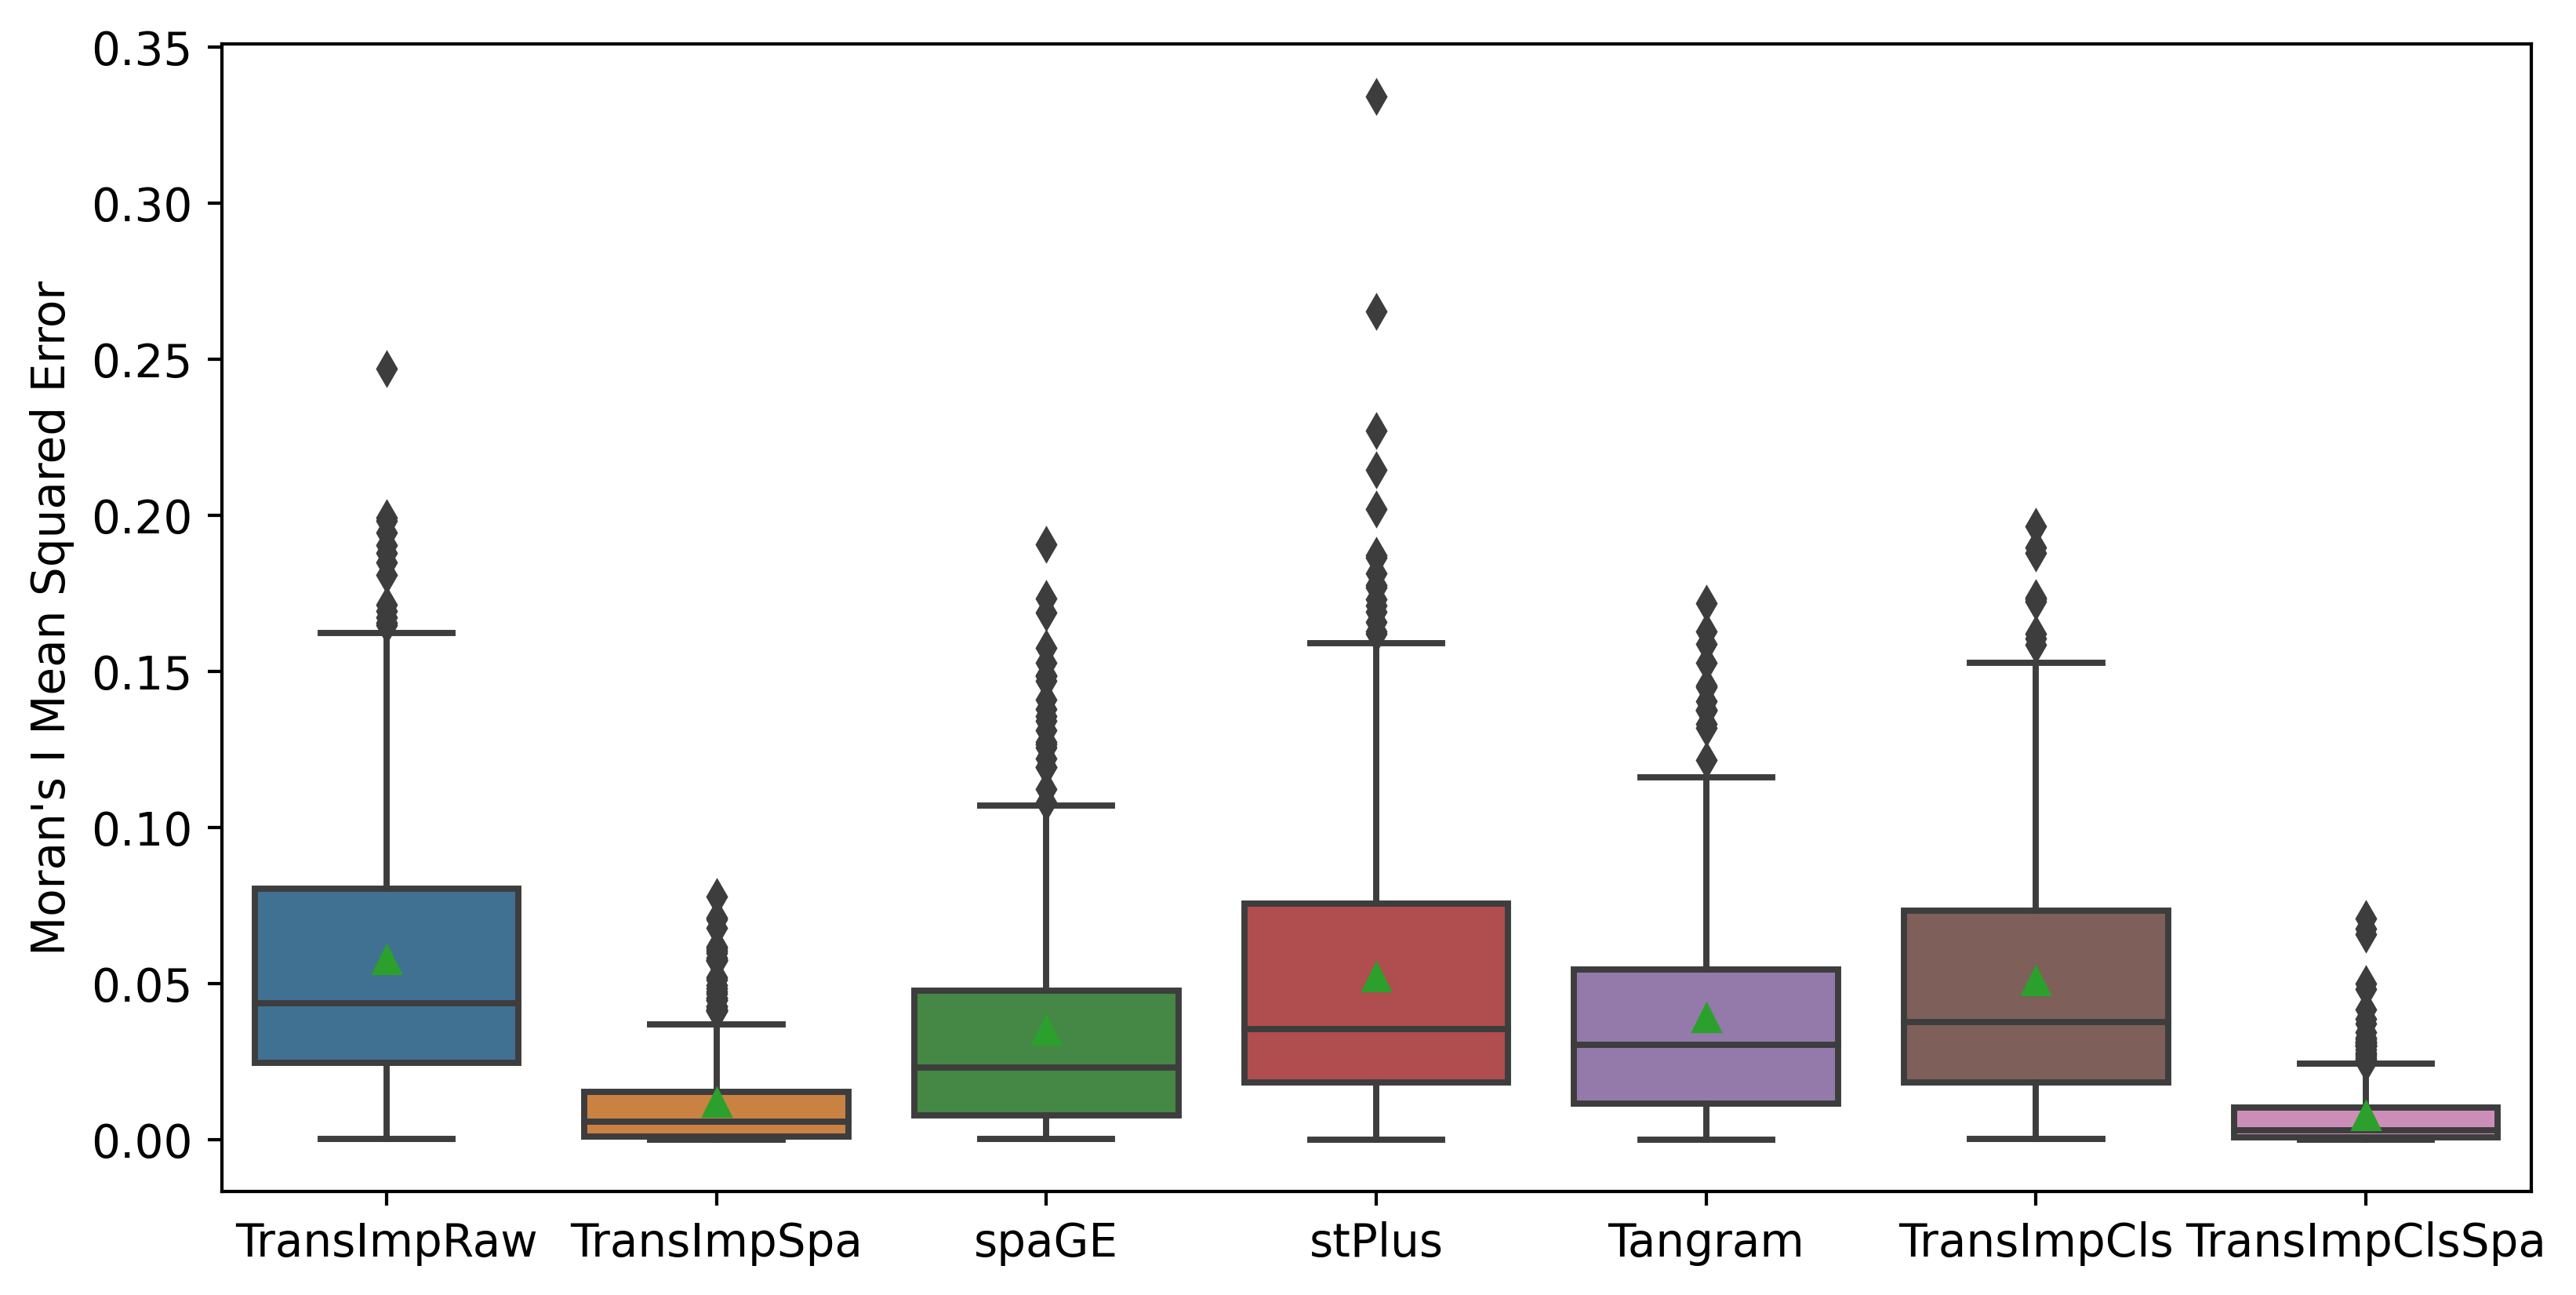

In [6]:
plt.figure(figsize=(10, 5), dpi= 380)
sns.boxplot(data = df_se_moranI, order=method_order, showmeans=True, palette=color).set(
    ylabel="Moran's I Mean Squared Error"
)

In [7]:
n_clusters = len(spa_adata.obs.celltype_mapped_refined.unique())
print(f"{n_clusters} clusters")

real_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                    connectivity=spa_adata.obsp['spatial_connectivities'],
                                    ).fit_predict(StandardScaler().fit_transform(spa_adata.X))
spa_cluster_metrics = {}
for method in sorted(imp_adatas.keys()):
    imp_adata = imp_adatas[method]
    pred_clss = AgglomerativeClustering(n_clusters=n_clusters, 
                                         connectivity=spa_adata.obsp['spatial_connectivities'],
                                         ).fit_predict(StandardScaler().fit_transform(imp_adata.X))
    ars = adjusted_rand_score(real_clss, pred_clss)
    amis = adjusted_mutual_info_score(real_clss, pred_clss)
    homo = homogeneity_score(real_clss, pred_clss)
    nmi = normalized_mutual_info_score(real_clss, pred_clss)
    spa_cluster_metrics[method] = {"ARS":ars, "AMIS":amis, 'HOMO': homo, 'NMI':nmi}
    pd.DataFrame(spa_cluster_metrics).to_csv("../../output/clustering/seqFISH_SingleCell.csv")
    print(f"Cluster on Raw Expression vs  on {method} Predicted Expression\n - ARS: {ars:.6f}, AMIS: {amis:.6f}, HOMO: {homo:.6f}, NMI: {nmi:.6f}")

24 clusters
Cluster on Raw Expression vs  on Tangram Predicted Expression
 - ARS: 0.368551, AMIS: 0.638605, HOMO: 0.633941, NMI: 0.639183
Cluster on Raw Expression vs  on TransImpCls Predicted Expression
 - ARS: 0.436774, AMIS: 0.664433, HOMO: 0.653164, NMI: 0.664975
Cluster on Raw Expression vs  on TransImpClsSpa Predicted Expression
 - ARS: 0.419457, AMIS: 0.653635, HOMO: 0.640768, NMI: 0.654195
Cluster on Raw Expression vs  on TransImpRaw Predicted Expression
 - ARS: 0.477770, AMIS: 0.692230, HOMO: 0.691209, NMI: 0.692717
Cluster on Raw Expression vs  on TransImpSpa Predicted Expression
 - ARS: 0.389309, AMIS: 0.662821, HOMO: 0.650196, NMI: 0.663368
Cluster on Raw Expression vs  on spaGE Predicted Expression
 - ARS: 0.377816, AMIS: 0.646354, HOMO: 0.626173, NMI: 0.646935
Cluster on Raw Expression vs  on stPlus Predicted Expression
 - ARS: 0.288612, AMIS: 0.601237, HOMO: 0.582604, NMI: 0.601892


TransImpRaw pred - true ratio above 0.1: 0.914530
TransImpSpa pred - true ratio above 0.1: 0.324786
TransImpCls pred - true ratio above 0.1: 0.834758
TransImpClsSpa pred - true ratio above 0.1: 0.202279
stPlus pred - true ratio above 0.1: 0.863248
Tangram pred - true ratio above 0.1: 0.780627
spaGE pred - true ratio above 0.1: 0.698006


Text(0.5, 0.98, "True Moran's I v.s. (Pred - True) Moran's I")

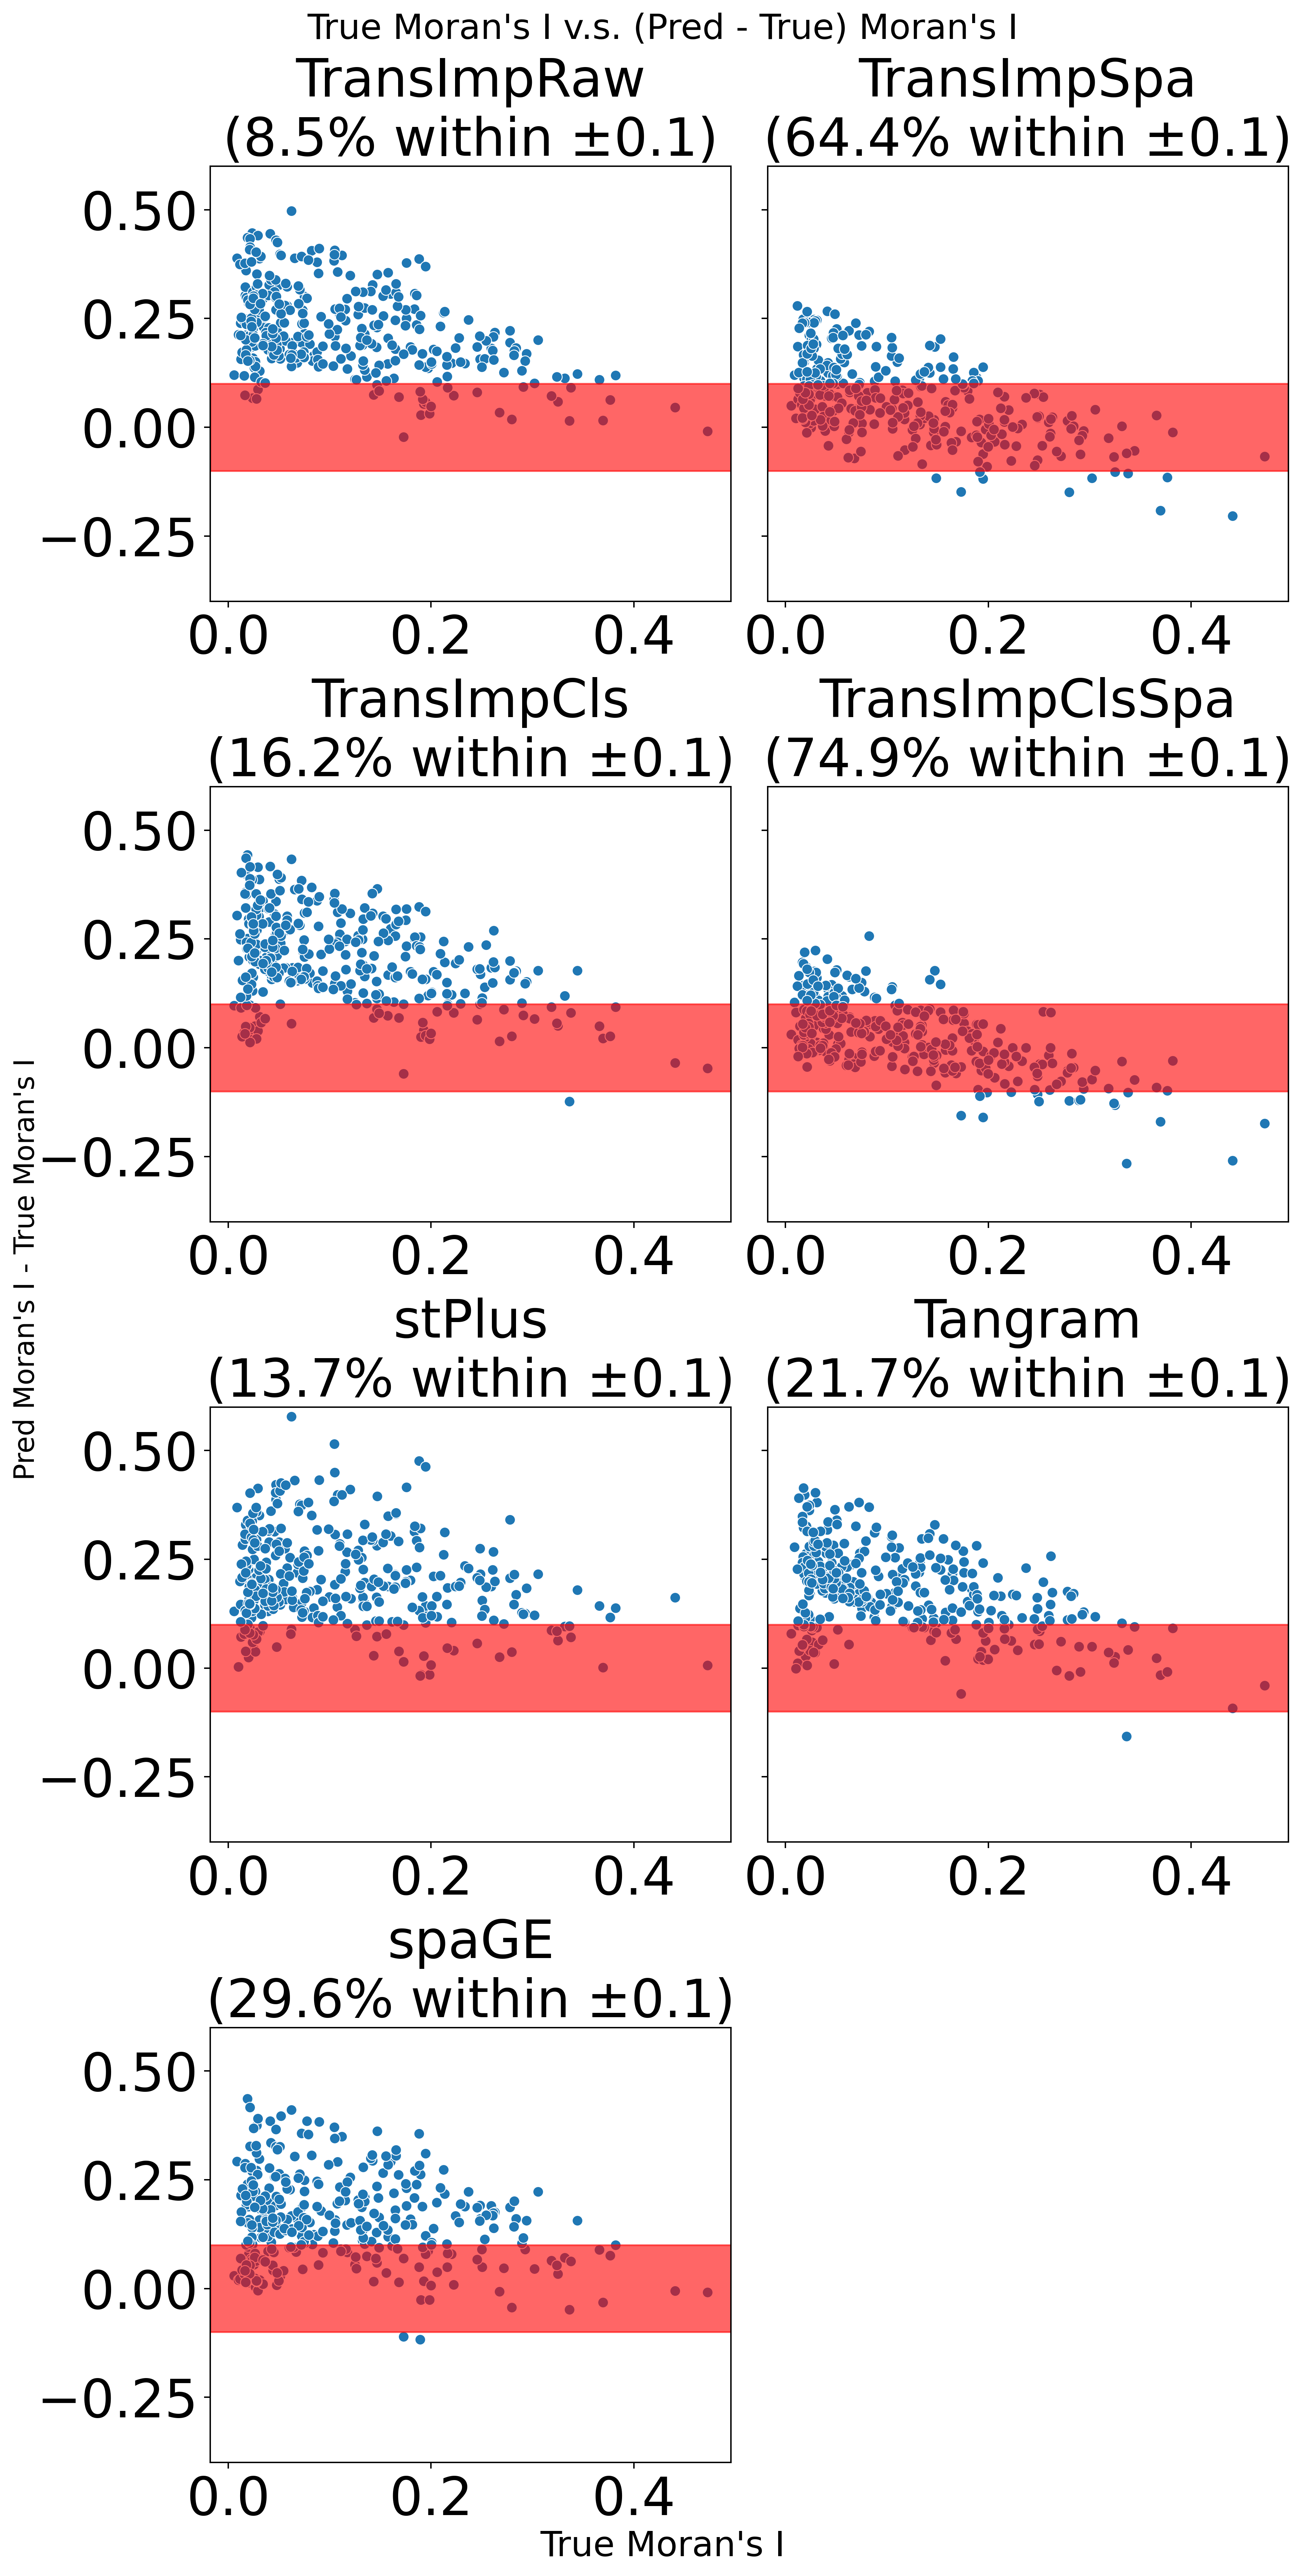

In [8]:
plt.rcParams.update({"font.size":30, 'axes.titlesize':30})

fig, axis = plt.subplots(4,2, sharey=True, constrained_layout=True)
fig.set_figwidth(10)
fig.set_figheight(20)
fig.set_dpi(350)
for idx, method in enumerate(['TransImpRaw', 'TransImpSpa', "TransImpCls", 'TransImpClsSpa', 'stPlus', 'Tangram', 'spaGE', None]):
    
    ax = axis[idx//2, idx%2]
    if method is None:
        ax.axis('off')
        break    
    ax.axis(ymin=-0.4, ymax=0.6)
    sns.scatterplot(x=df_I.truth, y=df_I[method]-df_I.truth, ax=ax)
    ratio = (np.abs(df_I.truth-df_I[method]) < 0.1).sum()/df_I.shape[0]
    neg_ratio = ((df_I.truth-df_I[method]) < -0.1).sum()/df_I.shape[0]
    print(f"{method} pred - true ratio above 0.1: {neg_ratio:.6f}")
    ax.axhspan(-0.1, 0.1, facecolor='0.5', alpha=0.6, color='r')
    ax.set_title(f'{method if method != "transImpute" else "transImp"}\n({ratio:.1%} within ±0.1)')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
fig.text(0.5, -0.01, "True Moran's I", ha='center', fontsize=20)    
fig.text(-0.015, 0.5, "Pred Moran's I - True Moran's I", va='center', rotation='vertical', fontsize=16)
fig.suptitle("True Moran's I v.s. (Pred - True) Moran's I", fontsize=20)
# fig.savefig("../../output/seqfish_moranI_cmp.png", dpi=350)

I                   0.281574
pval_norm           0.000000
var_norm            0.000006
pval_norm_fdr_bh    0.000000
Name: Ttn, dtype: float64


<Figure size 7600x7600 with 0 Axes>

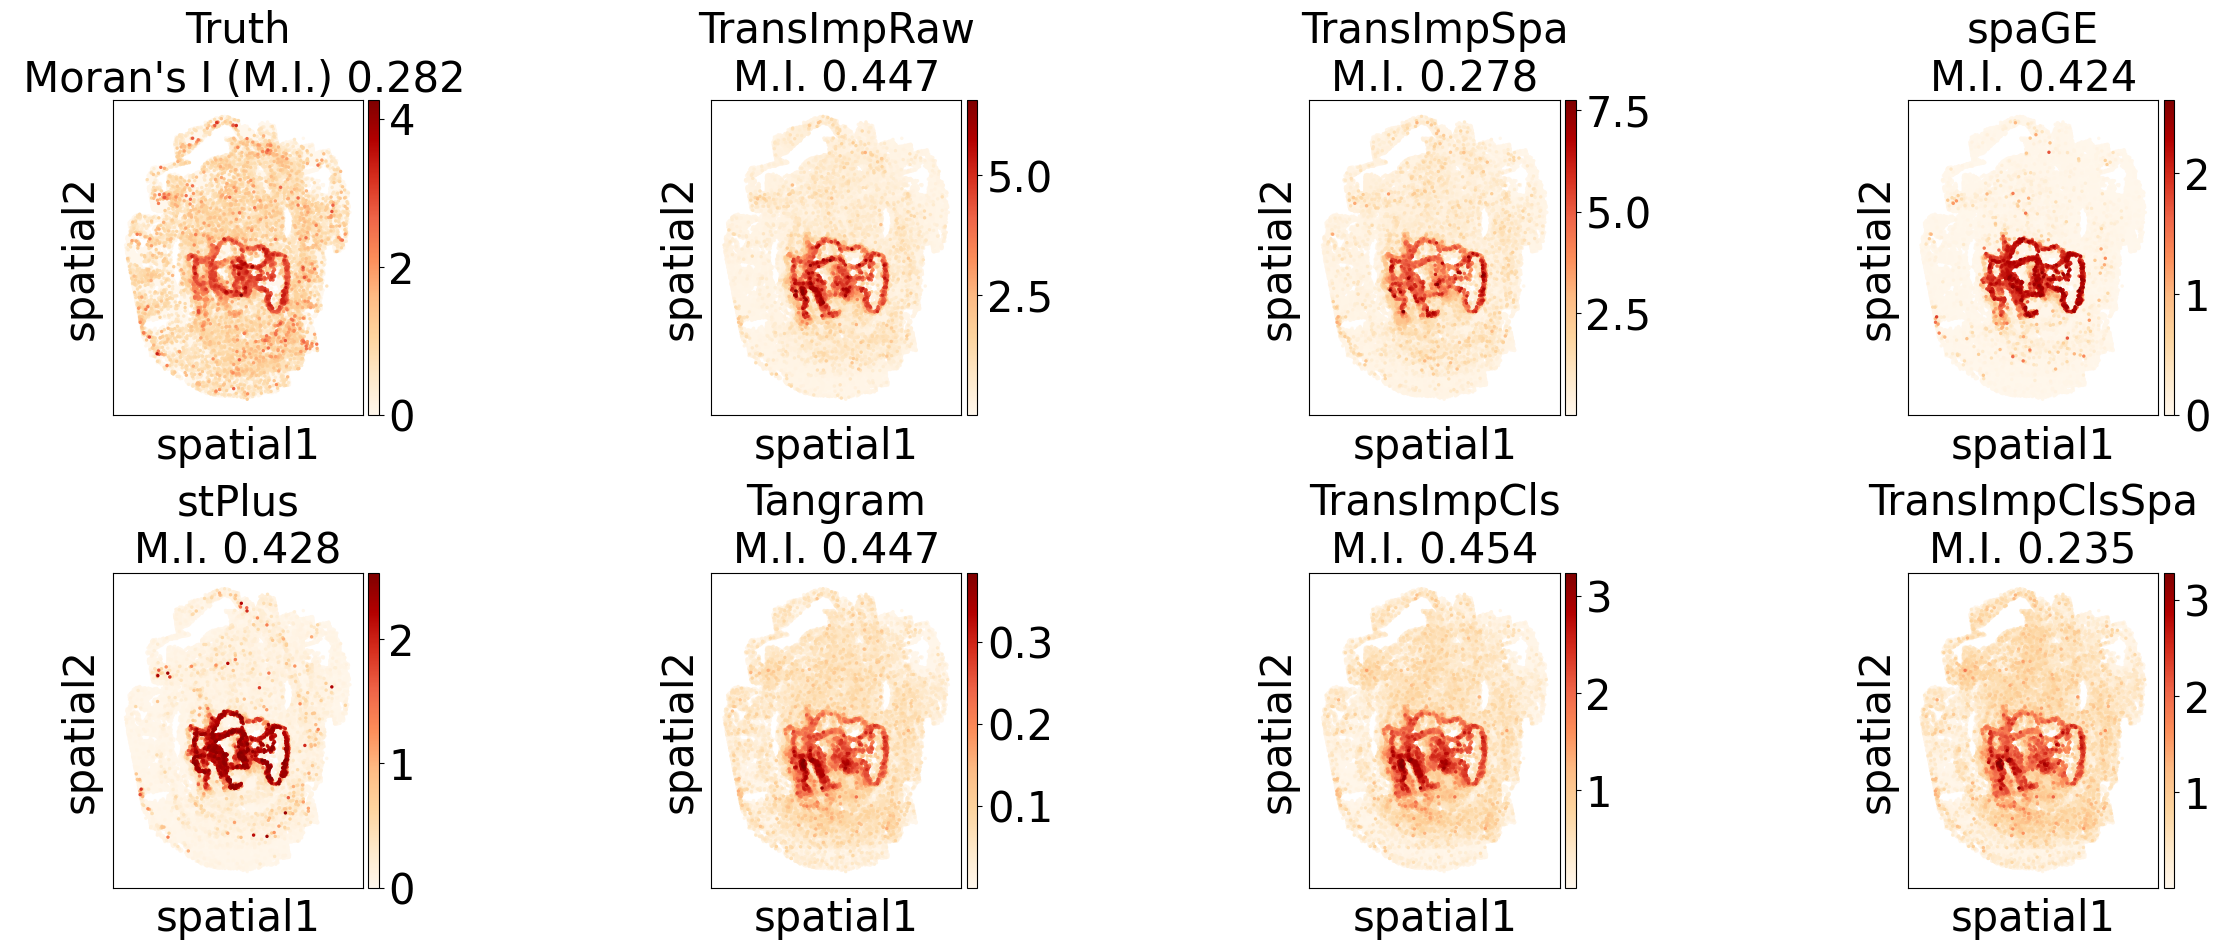

In [9]:
from turtle import title

def plot(gene):
    plt.figure(figsize=(20, 20), dpi= 380)
    plt.rcParams.update({"font.size":30, 'axes.titlesize':30})
    exprs = [spa_adata[:, gene].X.toarray().flatten()]
    titles = [f"Truth\n Moran's I (M.I.) {spa_adata.uns['moranI'].loc[gene].I:.3f}"]
    # sc.pl.spatial(spa_adata, color=[gene], spot_size=0.1, title='Truth')
    print(spa_adata.uns['moranI'].loc[gene])
    for method in method_order:
        imp_adata = imp_adatas[method]    
           
        titles.append(f'{method if method != "transImpute" else "transImp" }\nM.I. {imp_adatas[method].uns["moranI"].I.loc[gene]:.3f}')# ; S.R. {df_corr[method].loc[gene]:.3f}')
        exprs.append(imp_adata[:, gene].X.toarray().flatten())
    tmp_adata = sc.AnnData(np.array(exprs).T)
    tmp_adata.var_names = titles
    tmp_adata.obsm['spatial'] = spa_adata.obsm['spatial']
    sc.pl.spatial(tmp_adata, color=titles, spot_size=0.1, title=titles, color_map='OrRd', legend_fontsize=10, hspace=0.5, ncols=4)
plot("Ttn")

I                   0.245251
pval_norm           0.000000
var_norm            0.000006
pval_norm_fdr_bh    0.000000
Name: Six3, dtype: float64


<Figure size 7600x7600 with 0 Axes>

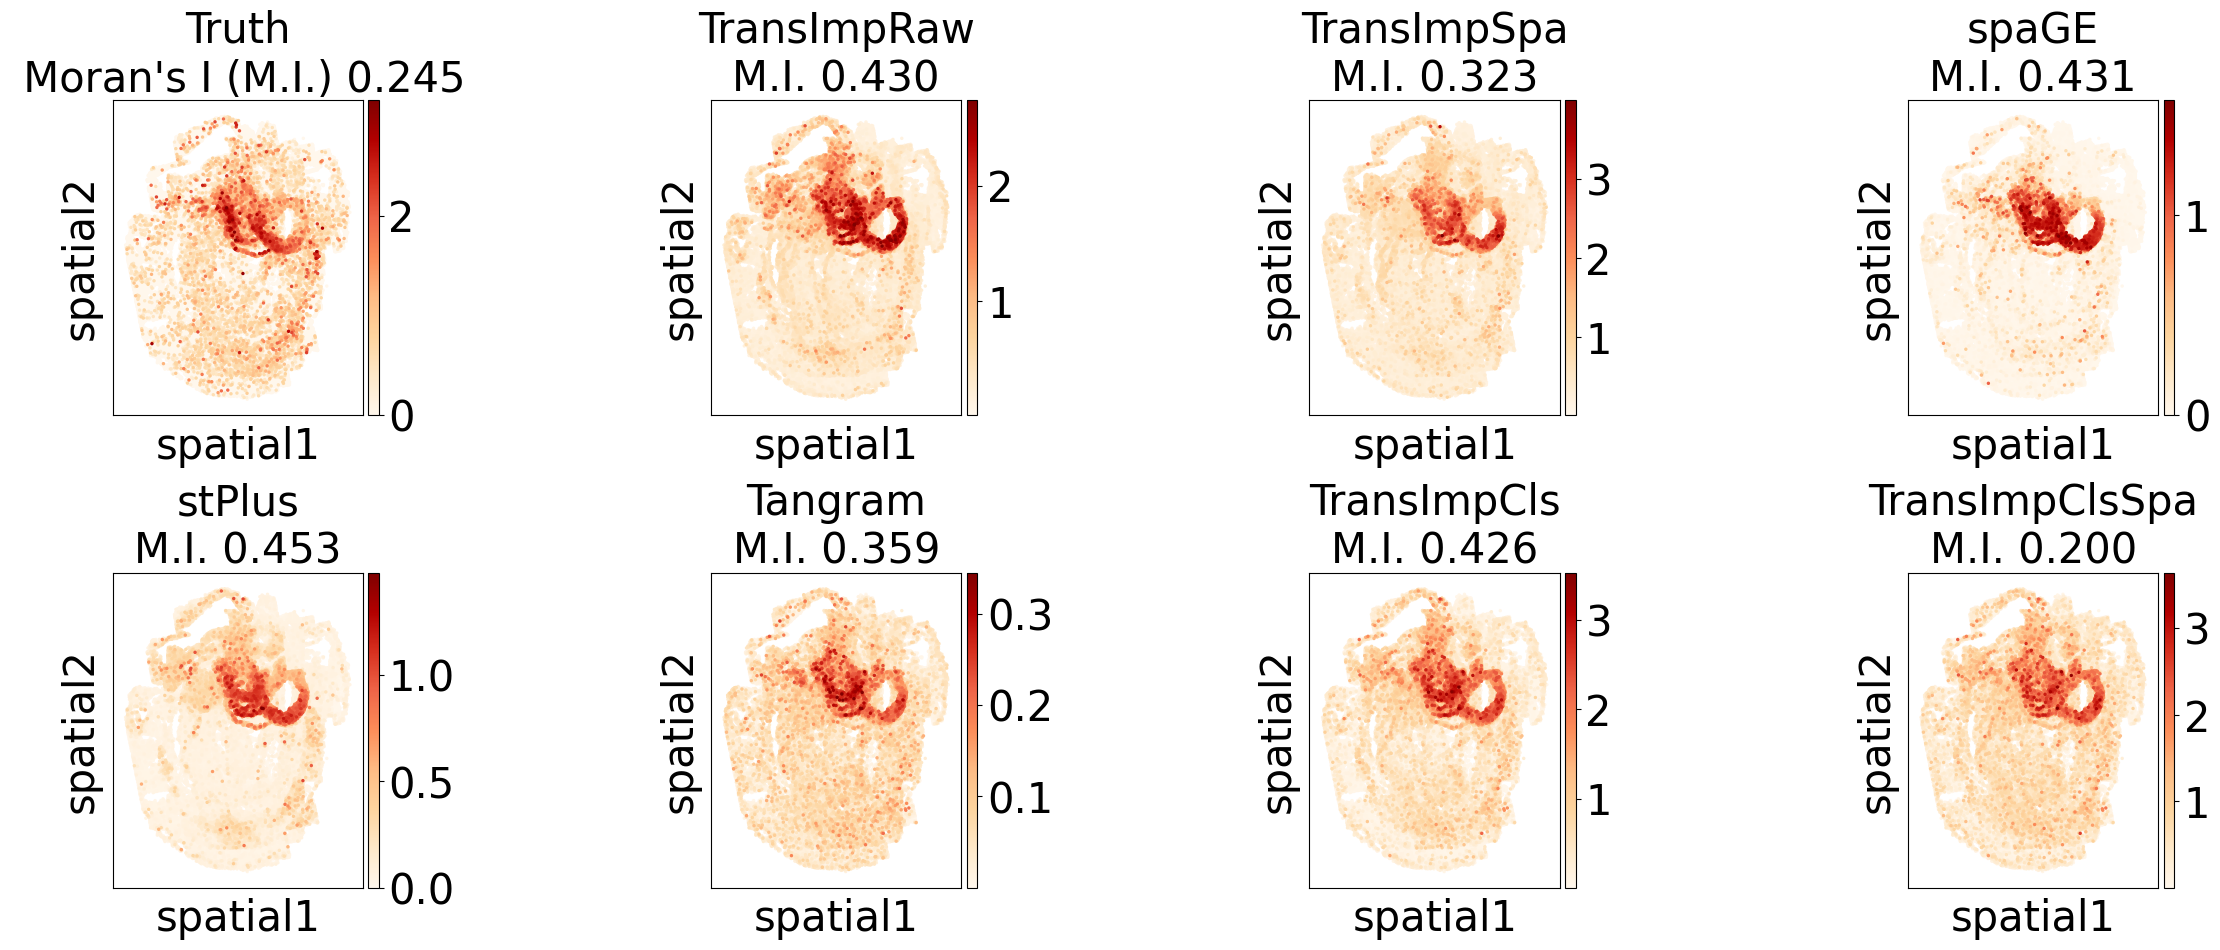

In [10]:
plot("Six3")

I                   0.305425
pval_norm           0.000000
var_norm            0.000006
pval_norm_fdr_bh    0.000000
Name: Sox2, dtype: float64


<Figure size 7600x7600 with 0 Axes>

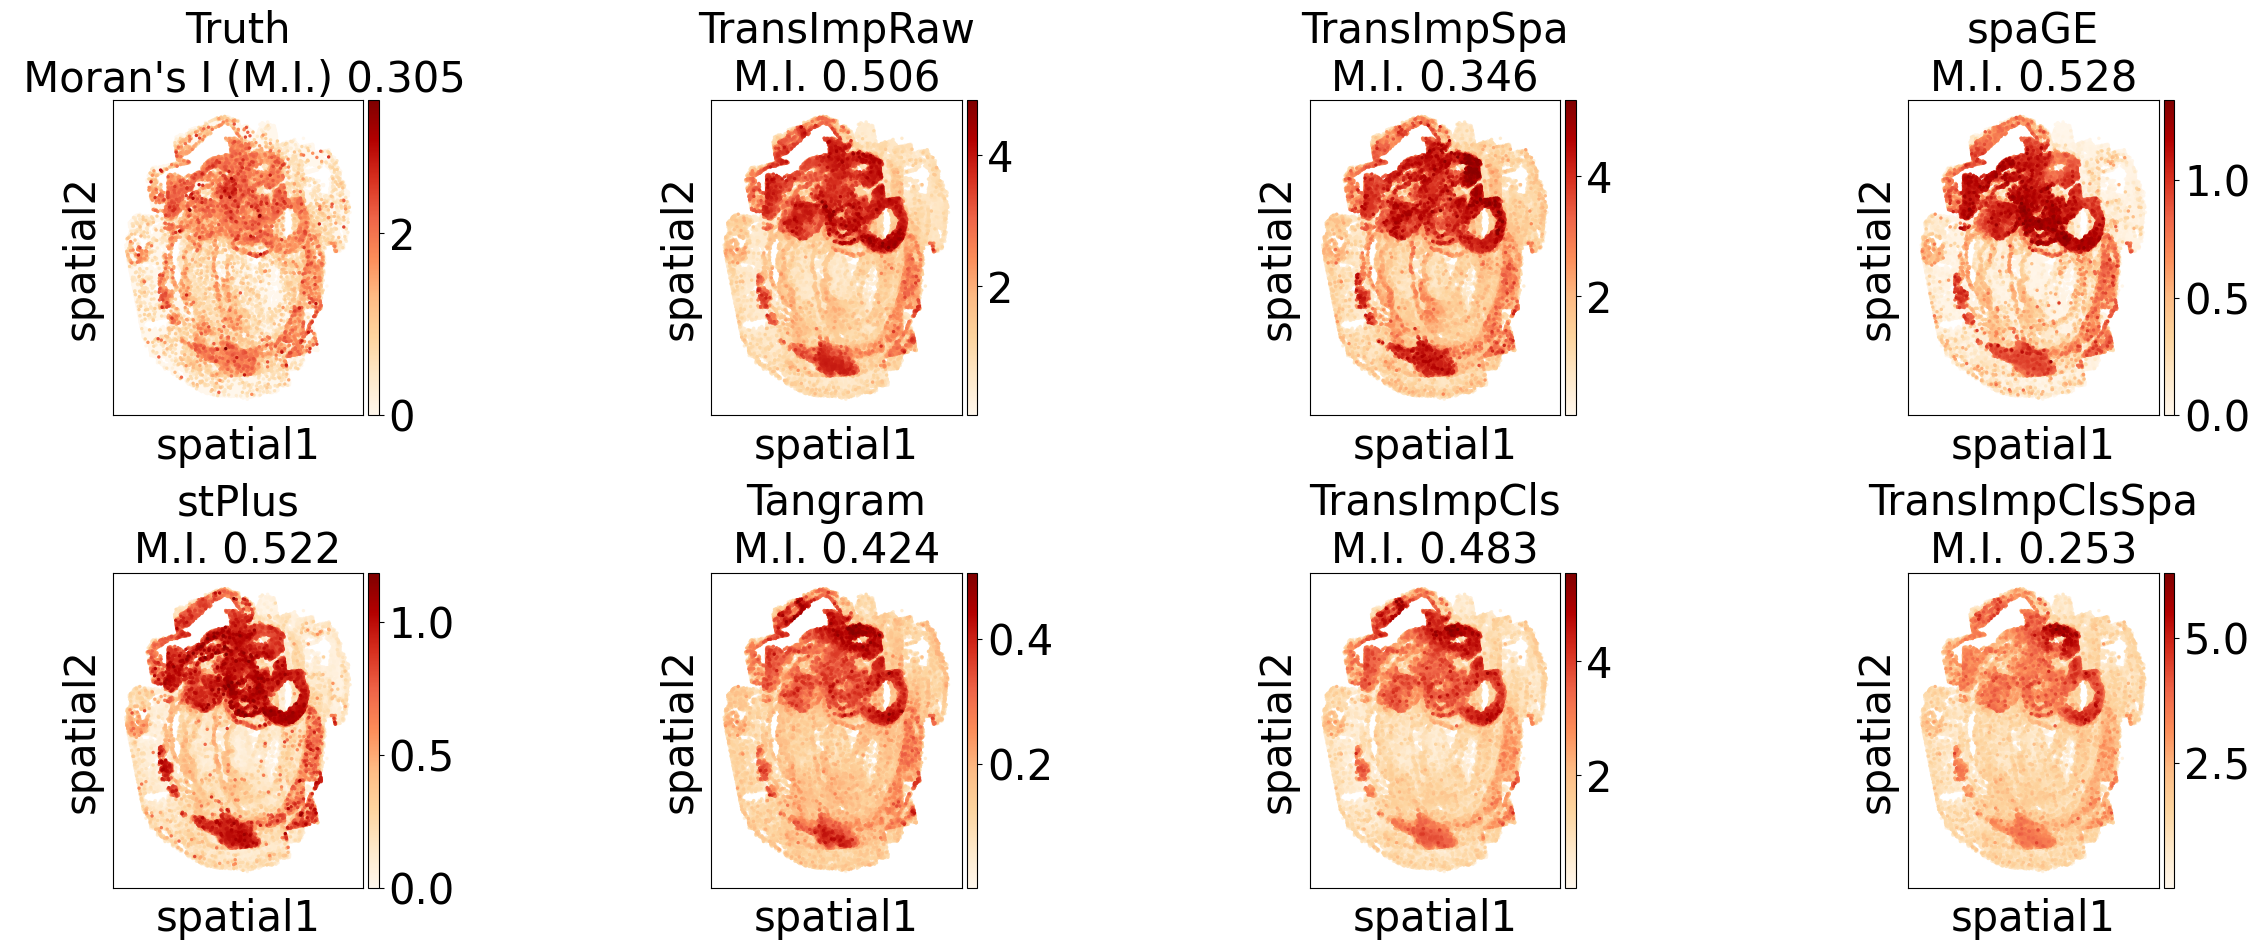

In [11]:
plot("Sox2")